---
---
# TRAIN RESNET MODEL

### Dartmouth ECoG Lab

### version 1 (2021)
---
---

In [2]:
# libraries
from __future__ import print_function, division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
import os
import copy
import time
import random
import warnings 
import operator
warnings.filterwarnings('ignore')
import torch
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchtext import data
from sklearn import metrics
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.externals import joblib
from sklearn.utils import resample 
import splitfolders

# directories
data_dir = './cnn-detectorspect/'
image_dir = './IEDEXPORTS_SPECT/'


# SPLIT DATA

In [367]:
### split exported images into train, test, val dirs (80:10:10)
### note: make sure assigned dir is empty prior to running this! 
# splitfolders.ratio(image_dir, output=data_dir, seed=1031, ratio=(0.7, 0.15, 0.15))

### print number of files in each dir:
path, dirs, files = next(os.walk(data_dir + "train/IED"))
train_ieds = len(files)
print("TRAIN IEDS: %d" %train_ieds)
path2, dirs2, files2 = next(os.walk(data_dir + "train/NONIED"))
train_nonieds = len(files2)
print("TRAIN NONIEDS: %d" %train_nonieds)

path3, dirs3, files3 = next(os.walk(data_dir + "val/IED"))
val_ieds = len(files3)
print("VAL IEDS: %d" %val_ieds)
path4, dirs4, files4 = next(os.walk(data_dir + "val/NONIED"))
val_nonieds = len(files4)
print("VAL NONIEDS: %d" %val_nonieds)

TRAIN IEDS: 688
TRAIN NONIEDS: 1054
VAL IEDS: 147
VAL NONIEDS: 225


# IMAGE PREPROCESSING

Visualization of a few training images:
---------------------------------------


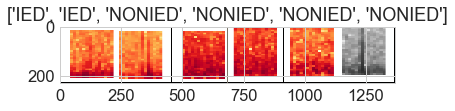

In [369]:
### augment images for resnet: done to prevent overfitting
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256), # 224
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Pad(1, fill=0, padding_mode='constant'),
        transforms.RandomGrayscale(p=0.2), # make sure this is always after pad transform
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # not too important.
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.Pad(1, fill=0, padding_mode='constant'),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=0) ####### batch d:8
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### visualize some training images to understand the data augmentations
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause so that plots are updated

### Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
imshow_num = 6
inputs = inputs[:imshow_num]
classes = classes[:imshow_num]
### Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print("Visualization of a few training images:")
print("---------------------------------------")
imshow(out, title=[class_names[x] for x in classes])
# print(classes)
# print(title)

# MODEL TRAINING

In [370]:
### MODEL ARCHITECTURE:
# model = models.resnet101(pretrained=False) ### default used: RESNET101 best performance so far... 
# model = models.resnet34(pretrained=False) ### works just as well as resnet101
model = models.resnet18(pretrained=False)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,2) # size of each input sample 
# model_f = models.alexnet(pretrained=False) # does not need size of each input sample, etc. (above)
model = model.to(device)

# loss function for model 
criterion = nn.CrossEntropyLoss()
# model optimizer 
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4) ### d: 0.001, 1e-4
# optimizer_f = optim.SGD(model_f.fc.parameters(), lr=0.01, momentum=0.7)
# decay the learning rate by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1) # 5,0.1

# move the input and model to GPU transposeeed if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [374]:
"""
#############################
# Function for model training
#############################
"""

stored_loss = []
stored_acc = []

output = []
predictions = []

def train_model(model,criterion,optimizer,scheduler,num_epochs=20):
    start=time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)
        
        # each epoch has training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # model.forward(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    output.append(outputs) 
                    predictions.append(preds) 
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            ### store loss and acc
            epoch_loss = running_loss / dataset_sizes[phase]
            stored_loss.append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            stored_acc.append(epoch_acc)
            
            print('{} loss: {:.4f} acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - start
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Val Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model


In [375]:
"""
#############
# TRAIN MODEL 
#############
"""

### run model 
model = train_model(model,criterion,optimizer,exp_lr_scheduler, num_epochs = 100) 


Epoch 0/99
----------
train loss: 0.6520 acc: 0.6447
val loss: 0.5916 acc: 0.7608

Epoch 1/99
----------
train loss: 0.3609 acc: 0.8548
val loss: 0.2926 acc: 0.8978

Epoch 2/99
----------
train loss: 0.3349 acc: 0.8691
val loss: 0.6126 acc: 0.7957

Epoch 3/99
----------
train loss: 0.3387 acc: 0.8662
val loss: 0.2781 acc: 0.9032

Epoch 4/99
----------
train loss: 0.3246 acc: 0.8777
val loss: 0.2542 acc: 0.9005

Epoch 5/99
----------
train loss: 0.2902 acc: 0.8915
val loss: 0.3464 acc: 0.8414

Epoch 6/99
----------
train loss: 0.2973 acc: 0.8858
val loss: 1.7341 acc: 0.3952

Epoch 7/99
----------
train loss: 0.2882 acc: 0.8909
val loss: 0.2618 acc: 0.9167

Epoch 8/99
----------
train loss: 0.3030 acc: 0.8783
val loss: 0.2489 acc: 0.9032

Epoch 9/99
----------
train loss: 0.2768 acc: 0.8995
val loss: 0.3860 acc: 0.8414

Epoch 10/99
----------
train loss: 0.2596 acc: 0.8955
val loss: 0.2164 acc: 0.9167

Epoch 11/99
----------
train loss: 0.2694 acc: 0.8921
val loss: 0.5998 acc: 0.7177

Ep

## SAVE MODEL OUTPUTS

In [376]:
### reformat tensors (predictions, outputs) for export

### function to convert CEL values to probabilities for each class:
def probConvert(value): # input single tensor object
    conversion1 = nn.LogSoftmax() # conversion: crossentropyloss -> prob
    val = torch.exp(conversion1(value))
    return val 

### function to reformat outputs from model training:
def celReformat(output, predictions):
    batchpreds = []
    batchoutputs = []
    batchprob0 = []
    batchprob1 = []

    for i in range(len(output)):
        batchpreds.append(predictions[i].tolist())
        outp = probConvert(output[i]) # pred prob of 0 (IED), pred prob of 1 (NONIED)
        outp = [item for sublist in outp.tolist() for item in sublist] # flatten to single list: odds = ied prob, evens = nonied prob
        batchprob0.append(outp[::2])
        batchprob1.append(outp[1::2])

    batchpreds = [item for sublist in batchpreds for item in sublist] # flatten list of lists
    batchprob0 = [item for sublist in batchprob0 for item in sublist] # flatten list of lists
    batchprob1 = [item for sublist in batchprob1 for item in sublist] # flatten list of lists

    return (batchpreds, batchprob0, batchprob1)

### run function 
pred, prob0, prob1 = celReformat(output, predictions)

### store outputs
outputdf = pd.DataFrame(
    {'predictions': pred,
     'prob_ied': prob0,
     'prob_nonied': prob1})


In [378]:

### STORE MODEL OUTPUTS; SAVE BEST PERFORMING MODEL:
# store loss (even = training rows, odd = validation rows)
stored_loss = pd.DataFrame(stored_loss)
# store acc (even = training rows, odd = validation rows)
stored_acc = pd.DataFrame(stored_acc)

# export
stored_loss.to_csv(data_dir+'/stored_loss.csv')
stored_acc.to_csv(data_dir+'/stored_acc.csv')
outputdf.to_csv(data_dir+'/stored_outputs.csv')


"""
############
# SAVE MODEL
############
"""
# export model 
torch.save(model, data_dir+'/model_aied18.pt') ############################## change output based on pretrained


---

---

# MODEL PERFORMANCE METRICS

### ACCURACY AND LOSS OVER TIME (EPOCHS):

MODEL:
--------------------------- 
Best EPOCH: 31
Min validation loss: 0.151366



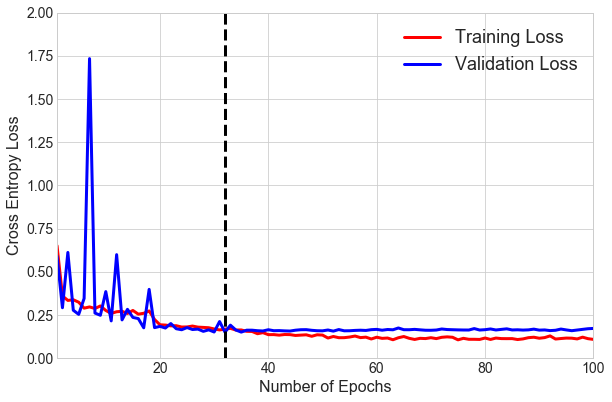

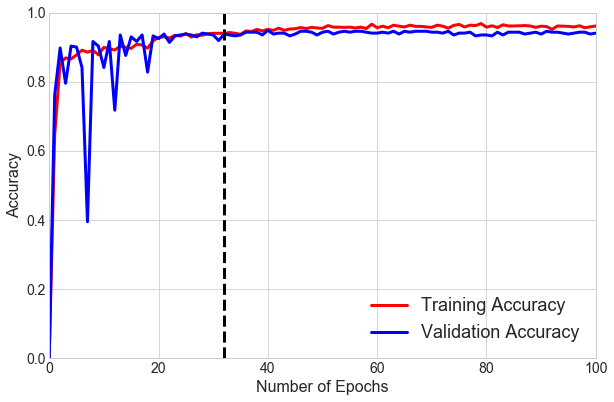

In [8]:
### 0 = ied, 1 = nonied --- classes
# import and resort saved data output
# loss
lossF = pd.read_csv(data_dir+'stored_loss.csv')
lossF = pd.DataFrame(lossF['0'])
train_loss_f_load = lossF.iloc[::2] # even rows (0,2,4,...)
val_loss_f_load = lossF.iloc[1::2] # odd rows (1,3,5,...)
# acc 
acc = pd.read_csv(data_dir+'/stored_acc.csv')
acc = pd.DataFrame(acc['0'])
train_acc_load = acc.iloc[::2] # even rows (0,2,4,...)
new_row = pd.DataFrame({'0':0}, index =[0]) # add so starts at 0.
train_acc_load = pd.concat([new_row, train_acc_load])
val_acc_load = acc.iloc[1::2] # odd rows (1,3,5,...)
val_acc_load = pd.concat([new_row, val_acc_load])

"""
########
# PLOT:
########
"""
# plot of model trained from scratch 
# change range based on number of epochs (1:epochs+1)
n_epochs = 100 ######################################################################## change epoch based on training 
end = n_epochs + 1

# fine best epoch (min validation loss)
lossList = (val_loss_f_load['0'].values) # reloaded data 
# lossList = val_loss_f.values # direct from model training 
epochMin, minLoss = min(enumerate(lossList), key=operator.itemgetter(1))

print('MODEL:')
print('--------------------------- ')
print('Best EPOCH: %s' % (epochMin))
print('Min validation loss: %f' % (minLoss))
print('')

### GENERAL PLOT PARAMS:
train_color = 'red'
val_color = 'blue'
linw = 3
plt.style.use('seaborn-whitegrid') ######################### plot style: seaborn-whitegrid
plt.rcParams.update({'font.size': 18, 'font.family': 'Arial'})
labelsize = 16

### LOSS PLOT:
plt.figure(figsize = (9,6)) # 11,7
plt.subplots_adjust(wspace=0.6, hspace=0.6, left=0.1, bottom=0.22, right=0.96, top=0.96)
plt.plot(range(1,end),train_loss_f_load,label='Training Loss', color = train_color, linewidth = linw) 
plt.plot(range(1,end),val_loss_f_load,label='Validation Loss', color = val_color, linewidth = linw)
plt.title('')
plt.xlabel('Number of Epochs', fontsize = labelsize)
plt.ylabel('Cross Entropy Loss', fontsize = labelsize)
plt.ylim(0,2)
plt.xlim(1,n_epochs)
# plt.ylim(0.5,2)
plt.legend(loc='upper right')
plt.axvline(x=32, color="black", linewidth=3, linestyle='dashed') # add vertical line for epoch with max loss 
# plt.show()
plt.tight_layout()
plt.tick_params(axis='both', labelsize=14)
plt.savefig(data_dir+"cel_plot.png", dpi = 600)

### ACC PLOT:
plt.figure(figsize = (9,6))
plt.subplots_adjust(wspace=0.6, hspace=0.6, left=0.1, bottom=0.22, right=0.96, top=0.96)
plt.plot(range(0,end),train_acc_load,label='Training Accuracy', color = train_color, linewidth = linw) # 1,end 
plt.plot(range(0,end),val_acc_load,label='Validation Accuracy', color = val_color, linewidth = linw)
plt.title('')
plt.xlabel('Number of Epochs', fontsize = labelsize)
plt.ylabel('Accuracy', fontsize = labelsize)
plt.ylim(0,1)
plt.xlim(0,n_epochs)
plt.legend(loc='lower right')
plt.axvline(x=32, color="black", linewidth=3, linestyle='dashed') # add vertical line for epoch with max loss 
# plt.show()
plt.tight_layout()
plt.tick_params(axis='both', labelsize=14)
plt.savefig(data_dir+"acc_plot.png", dpi = 600)


# TEST SET DATA: ASSESSMENT 

In [169]:
### PREPARE TEST SET DATA:
data_dir = '/Users/robertquon/Desktop/ecoglab_scripts-others/spikeRater_ed/cnn-detectorspect/'
image_dir = '/Users/robertquon/Desktop/ecoglab_scripts-others/spikeRater_ed/IEDEXPORTS_SPECT/'

# LOAD/AUGMENT TEST IMAGES:
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.Pad(1, fill=0, padding_mode='constant'),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True, num_workers=0) 
              for x in ['test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
class_names = image_datasets['test'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [170]:
### import best performing --- saved model 
### note: model class must be defined somewhere
model = torch.load(data_dir+'model_aied18.pt')

y_pred = []
y_true = []
output = []
# model.eval()

with torch.no_grad():
    for inputs,labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _,predicted = torch.max(outputs, 1)
        pred = predicted.numpy()
        lab = labels.numpy()
        y_pred.append(pred)
        y_true.append(lab)
        output.append(outputs)

        
### reformat tensors (predictions, outputs) for export
### function to convert CEL values to probabilities for each class:
def probConvert(value): # input single tensor object
    conversion1 = nn.LogSoftmax() # conversion: crossentropyloss -> prob
    val = torch.exp(conversion1(value))
    return val 

### function to reformat outputs from model training:
def celReformat(output, predictions):
    batchpreds = []
    batchoutputs = []
    batchprob0 = []
    batchprob1 = []

    for i in range(len(output)):
        batchpreds.append(predictions[i].tolist())
        outp = probConvert(output[i]) # pred prob of 0 (IED), pred prob of 1 (NONIED)
        outp = [item for sublist in outp.tolist() for item in sublist] # flatten to single list: odds = ied prob, evens = nonied prob
        batchprob0.append(outp[::2])
        batchprob1.append(outp[1::2])

    batchpreds = [item for sublist in batchpreds for item in sublist] # flatten list of lists
    batchprob0 = [item for sublist in batchprob0 for item in sublist] # flatten list of lists
    batchprob1 = [item for sublist in batchprob1 for item in sublist] # flatten list of lists

    return (batchpreds, batchprob0, batchprob1)

### run function 
pred, prob0, prob1 = celReformat(output, y_pred)

truelabel = [item for sublist in y_true for item in sublist] # flatten list of lists

### store outputs
test_outputs = pd.DataFrame(
    {'predictions': pred,
     'true': truelabel,
     'prob_ied': prob0,
     'prob_nonied': prob1})


In [171]:
test_outputs[:3]

,predictions,true,prob_ied,prob_nonied
0,1,1,0.164257,0.835743
1,1,1,0.010195,0.989805
2,1,1,0.018625,0.981375


CONFUSION MATRIX:
-----------------
              pred:class 0  pred:class 1
true:class 0           135            14
true:class 1            10           217


PER-CLASS ACCURACIES:
--------------------
Class 0 Accuracy = 0.906040
Class 1 Accuracy = 0.955947

where class 0 is IED, class 1 is NONIED



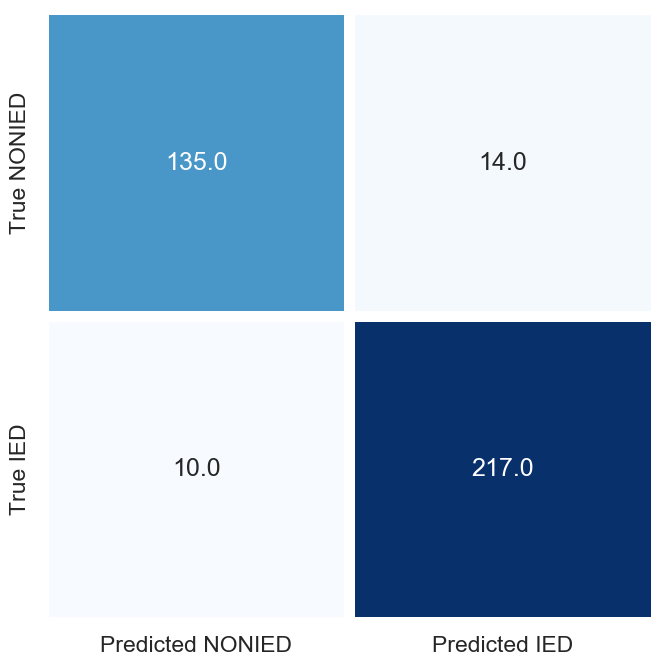

In [172]:
### COMPUTE CONFUSION MATRIX:
y_true = test_outputs.true.values
y_pred = test_outputs.predictions.values

cm = confusion_matrix(y_true, y_pred)
print('CONFUSION MATRIX:')
print('-----------------')
cmtx = pd.DataFrame(
    cm, 
    index=['true:class 0', 'true:class 1'], 
    columns=['pred:class 0', 'pred:class 1']
)
print(cmtx)
print('')
print('')
# COMPUTE PER-CLASS ACCURACIES:
print('PER-CLASS ACCURACIES:')
print('--------------------')
# normalize the diagonal values
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#The diagonal entries are the accuracies of each class
classAccuracies = cm.diagonal()
class0acc = classAccuracies[0]
class1acc = classAccuracies[1]
print('Class 0 Accuracy = %f' % class0acc)
print('Class 1 Accuracy = %f' % class1acc)
print('')
print('where class 0 is IED, class 1 is NONIED')
print('')

### NICER CONFUSION MATRIX FOR EXPORT:
plt.figure(figsize = (7,7))
sn.set(font_scale=1.5)
g = sn.heatmap(cmtx, 
           annot=True,
           cmap='Blues',
           fmt=".1f",
           annot_kws={'size':18},
           cbar=False,
           square=True,
           linewidths=7,
           linecolor='white', xticklabels=["Predicted NONIED", "Predicted IED"],
           yticklabels=["True NONIED", "True IED"])
g.set_yticklabels(g.get_yticklabels(), rotation = 90, va = 'center')
plt.tight_layout()
plt.savefig(data_dir+"cmtrx.png", dpi = 600)



### ROC CURVE:

0.9809892676581025


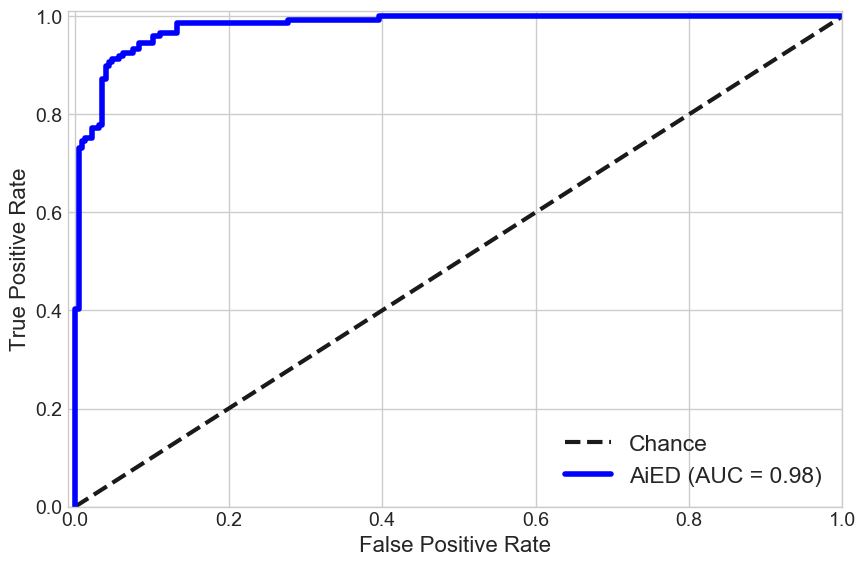

In [174]:
### ONLY bootstrap result to generate 95%CI of test data: i.e., random draw from test_outputs df --> store vals of each iter.
### repeat this bootstrap procedure for other performance metrics (below) - e.g., f1score, accuracy, sens, spec., etc.

### format inputs for ROC
y_true = test_outputs.true.values 
y_true = [0 if x==1 else 1 for x in y_true] ### switch here: 1 = IED, 0 = NONIED (use explicit ordering for ROC)
y_pred = test_outputs.prob_ied.values
### calculations:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_v = auc(fpr, tpr)
print(auc_v)

### PLOT:
plt.style.use('seaborn-whitegrid') ######################### plot style: seaborn-whitegrid
plt.figure(figsize = (9,6))
plt.figure(1)
labelsize = 16
plt.tick_params(axis='both', labelsize=14)

plt.plot([0, 1], [0, 1], 'k--', linewidth = 3)
plt.plot(fpr, tpr, label='area = {:.2f}'.format(auc_v), linewidth = 4, color = 'blue')
plt.xlabel('False Positive Rate', fontsize = labelsize)
plt.ylabel('True Positive Rate', fontsize = labelsize)
plt.title('')
plt.xlim(-0.01,1.0)
plt.ylim(0,1.01)
plt.legend(['Chance', 'AiED (AUC = {:.2f})'.format(auc_v)], loc='lower right')
plt.tight_layout()
plt.savefig(data_dir+"roc_plot.png", dpi = 600)


In [395]:
### BOOTSTRAP CIS: PLOT AS HISTOGRAM OF BOOTSTRAPPED CI AUC:
fpr_iters = []
tpr_iters = []
auc_iters = []
thresh_iters = []

for i in range(10000): # 1000, /4
    boot = resample(test_outputs, replace=True, n_samples=int(len(test_outputs)/4)) # random_state=10
    ### format inputs for ROC
    y_true = boot.true.values 
    y_true = [0 if x==1 else 1 for x in y_true] ### switch here: 1 = IED, 0 = NONIED (use explicit ordering for ROC)
    y_pred = boot.prob_ied.values
    ### calculations:
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_v = auc(fpr, tpr)
    ### store values for each iteration:
    fpr_iters.append(fpr)
    tpr_iters.append(tpr)
    auc_iters.append(auc_v)
    thresh_iters.append(thresholds)

### AUC 95%CI: 
sorted_scores = np.array(auc_iters)
sorted_scores.sort()
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("AUC 95% CI = [", round(confidence_lower,2), "-", round(confidence_upper,2), "]")
print(np.mean(auc_iters))

AUC 95% CI = [ 0.96 - 1.0 ]
0.9809520760231669


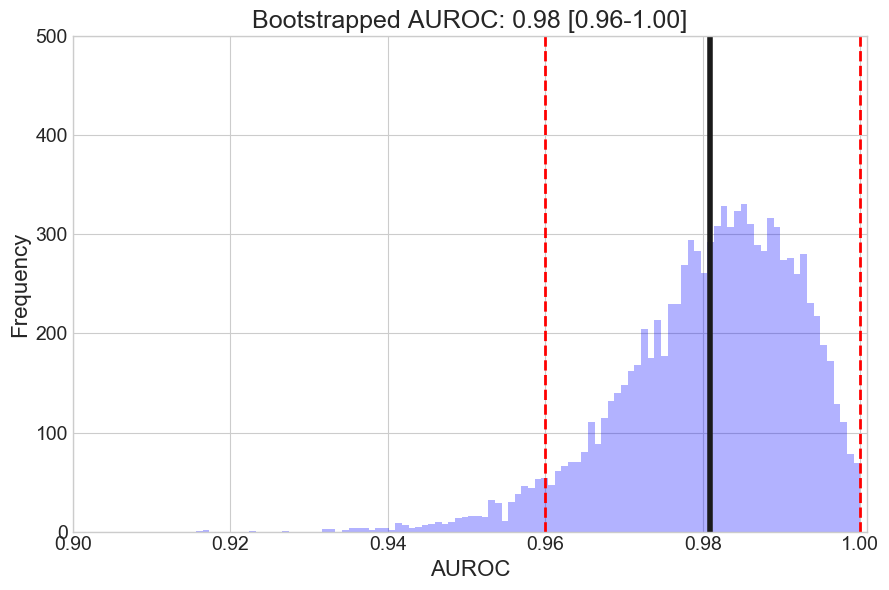

In [453]:
### PLOT: AUC BOOT
plt.style.use('seaborn-whitegrid') ######################### plot style: seaborn-whitegrid
plt.figure(figsize = (9,6))
labelsize = 16
titlesize = 18
plt.tick_params(axis='both', labelsize=14)

plt.hist(auc_iters, bins=100, color = 'blue', alpha = 0.3, histtype = 'stepfilled')
plt.axvline(np.mean(auc_iters), color='k', linestyle='solid', linewidth=4)
plt.axvline(0.96, color='red', linestyle='dashed', linewidth=2)
plt.axvline(1.0, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('AUROC', fontsize = labelsize)
plt.ylabel('Frequency', fontsize = labelsize)
plt.title('Bootstrapped AUROC: 0.98 [0.96-1.00]', fontsize = titlesize)
plt.xlim(0.90,1.0009)
plt.ylim(0,500)
# plt.show()
plt.tight_layout()
plt.savefig(data_dir+"auc_boots.png", dpi = 600)


### OTHER PERFORMANCE METRICS:

In [405]:

### COMPUTE CONFUSION MATRIX:
y_true = test_outputs.true.values
y_pred = test_outputs.predictions.values

cm = confusion_matrix(y_true, y_pred)
# Assigning columns names
cm_df = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])

def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = cm_df.values[1][1]
    TN = cm_df.values[0][0]
    FP = cm_df.values[0][1]
    FN = cm_df.values[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('='*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'F1-Score: {round(conf_f1,2)}')

confusion_metrics(cm_df)

### TODO: f1-score, sens, spec ; bootstrap CIs with test set. Maybe increase split 60:20:20?
### TODO: validate with externally annotated spike df


True Positives: 217
True Negatives: 135
False Positives: 14
False Negatives: 10
Accuracy: 0.94
Mis-Classification: 0.06
Sensitivity: 0.96
Specificity: 0.91
Precision: 0.91
F1-Score: 0.93


In [406]:
### BOOTSTRAP PERFORMANCE METRICS: ACCURACY, PRECISION, F1SCORE, SENSITIVITY, SPECIFICITY
accuracy = []
precision = []
f1score = []
sensitivity = []
specificity = []
class_ied_acc = []
class_nonied_acc = []

for i in range(10000):
    boot = resample(test_outputs, replace=True, n_samples=int(len(test_outputs)/4)) # random_state=10, change for size of each boot

    ### COMPUTE CONFUSION MATRIX:
    y_true = boot.true.values
    y_pred = boot.predictions.values

    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
    # values from cm
    TP = cm_df.values[1][1]
    TN = cm_df.values[0][0]
    FP = cm_df.values[0][1]
    FN = cm_df.values[1][0]
    
    ### per class accuracies
    # normalize the diagonal values
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #The diagonal entries are the accuracies of each class
    classAccuracies = cm.diagonal()
    class_ied_acc.append(classAccuracies[0])
    class_nonied_acc.append(classAccuracies[1])
    
    ### CALCULATE METRICS:
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    # calculate the sensitivity --- same formula as recall
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    # calculate precision
    conf_precision = (TP / float(TP + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    
    ### store values for each iteration:
    accuracy.append(conf_accuracy)
    precision.append(conf_precision)
    f1score.append(conf_f1)
    sensitivity.append(conf_sensitivity)
    specificity.append(conf_specificity)

### TODO: add per class accuracies here. 


In [407]:
### Function to calculate 95% CI 

def confint(score_list):
    sorted_scores = np.array(score_list)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
    m = np.mean(sorted_scores)
    
    return(confidence_lower, confidence_upper, m)


acc_ci = confint(accuracy)
f1_ci = confint(f1score)
prec_ci = confint(precision)
sens_ci = confint(sensitivity)
spec_ci = confint(specificity)
classied_ci = confint(class_ied_acc)
classnonied_ci = confint(class_nonied_acc)

print(".............","LOWER 95% CI -----", "UPPER 95% CI -------", "AVERAGE")
print("ACCURACY = ", acc_ci)
print("F1SCORE = ", f1_ci)
print("PRECISION = ", prec_ci)
print("SENSITIVITY = ", sens_ci)
print("SPECIFICITY = ", spec_ci)
print("IED_ACC = ", classied_ci)
print("NONIED_ACC = ", classnonied_ci)

print("")

### export 
outputdf_test = pd.DataFrame(
    {'accuracy': acc_ci,
     'f1score': f1_ci,
     'precision': prec_ci,
     'sensitivity': sens_ci,
     'specificity': spec_ci, 
     'class_ied_acc': classied_ci,
     'class_nonied_acc': classnonied_ci})

outputdf_test = np.transpose(outputdf_test)
outputdf_test.columns = ['LCI', 'UCI', 'MEAN']
outputdf_test.to_csv(data_dir+'/test_performance.csv')
outputdf_test


............. LOWER 95% CI ----- UPPER 95% CI ------- AVERAGE
ACCURACY =  (0.8936170212765957, 0.9787234042553191, 0.9363670212765959)
F1SCORE =  (0.9090909090909091, 0.9814814814814815, 0.9472554929787182)
PRECISION =  (0.8833333333333333, 0.9836065573770492, 0.9395674087276886)
SENSITIVITY =  (0.9074074074074074, 1.0, 0.9559700341978303)
SPECIFICITY =  (0.8222222222222222, 0.975, 0.9066114933717591)
IED_ACC =  (0.8222222222222222, 0.975, 0.9066114933717591)
NONIED_ACC =  (0.9074074074074074, 1.0, 0.9559700341978303)



,LCI,UCI,MEAN
accuracy,0.893617,0.978723,0.936367
f1score,0.909091,0.981481,0.947255
precision,0.883333,0.983607,0.939567
sensitivity,0.907407,1.000000,0.955970
specificity,0.822222,0.975000,0.906611
class_ied_acc,0.822222,0.975000,0.906611
class_nonied_acc,0.907407,1.000000,0.955970


# PLOT WHERE CNN IS FOCUING ON IMAGE

PREDICTION: 0 ..... PROB IED(0) =  95.67402005195618 ..... PROB NONIED(1) =  4.325985908508301

0 = IED, 1 = NONIED




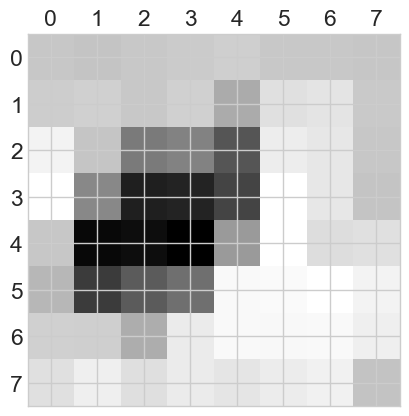

In [184]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

gradcam_dir = '/Users/robertquon/Desktop/ecoglab_scripts-others/spikeRater_ed/'
### https://medium.com/@stepanulyanin/grad-cam-for-resnet152-network-784a1d65f3

imgname = 'ied1.png' ### make sure matches image name in dir
imgnamehm = 'ied1_hm.png'


# LOAD/AUGMENT TEST IMAGES:
data_transforms = {
    'gradcam': transforms.Compose([
        transforms.Resize(224),
        transforms.Pad(1, fill=0, padding_mode='constant'),
#         transforms.RandomGrayscale(p=1.0), # make sure this is always after pad transform
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(gradcam_dir, x), data_transforms[x])
                  for x in ['gradcam']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=False, num_workers=0) 
              for x in ['gradcam']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['gradcam']}
class_names = image_datasets['gradcam'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# ResNet Class
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        # define the resnet152
        self.resnet = torch.load(data_dir+'model_aied18.pt')
        
        # isolate the feature blocks
        self.features = nn.Sequential(self.resnet.conv1,
                                      self.resnet.bn1,
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
                                      self.resnet.layer1, 
                                      self.resnet.layer2, 
                                      self.resnet.layer3, 
                                      self.resnet.layer4)
        
        # average pooling layer
        self.avgpool = self.resnet.avgpool
        # classifier
        self.classifier = self.resnet.fc
        # gradient placeholder
        self.gradient = None
    
    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        
        # extract the features
        x = self.features(x)
        # register the hook
        h = x.register_hook(self.activations_hook)
        # complete the forward pass
        x = self.avgpool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        
        return (x)

### LOAD model
# init the resnet
resnet = ResNet()
# set the evaluation mode
_ = resnet.eval()
# get the image
img, _ = next(iter(dataloaders['gradcam']))
pred = resnet(img)
pred_idx = int(pred.argmax(dim=1))
pred[:, pred_idx].backward()
# pull the gradients out of the model
gradients = resnet.get_gradient()
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
# get the activations of the last convolutional layer
activations = resnet.get_activations(img).detach()
# weight the channels by corresponding gradients
for i in range(512): # 512
    activations[:, i, :, :] *= pooled_gradients[i]
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()
# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)
# normalize the heatmap
heatmap /= torch.max(heatmap)
# draw the heatmap --- export
plt.matshow(heatmap.squeeze())
plt.tight_layout()

# make the heatmap to be a numpy array
heatmap = heatmap.numpy()
# interpolate the heatmap
img = cv2.imread(gradcam_dir+'gradcam/view/'+imgname)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_TURBO) # TURBO, JET
superimposed_img = heatmap * 0.9 + img


######################################################
# ### EXPORTS:
# cv2.imwrite(gradcam_dir+imgname, superimposed_img)
# plt.savefig(gradcam_dir+imgnamehm, dpi = 600)
######################################################


### PREDICTION PROBABILITY FOR IMAGE:

def probConvert(value): # input single tensor object
    conversion1 = nn.LogSoftmax() # conversion: crossentropyloss -> prob
    val = torch.exp(conversion1(value))
    return val 

pred_idx = int(pred.argmax(dim=1))
output = pred[0].tolist()
probs = probConvert(torch.FloatTensor(output))
print("PREDICTION:", pred_idx, "."*5, "PROB IED(0) = ", probs.tolist()[0]*100, "."*5, "PROB NONIED(1) = ", probs.tolist()[1]*100)
print("")
print("0 = IED, 1 = NONIED")
print("")
print("")


In [8]:
data_dir = './cnn-detectorspect/'
model = torch.load(data_dir+'model_aied18.pt')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# END